### Exercise 1: Classification with US Airline Sentiment Tweets

##### Import the libraries necessary for this project.

In [1]:
import numpy as np
import pandas as pd
import re
from nltk.tokenize import word_tokenize,RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from gensim.matutils import Sparse2Corpus
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import LdaModel,CoherenceModel,Word2Vec,FastText
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amagklara\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amagklara\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amagklara\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### 1. Data Preprocessing & Exploratory Data Analysis (EDA)

##### Load the Tweets dataset and print 5 first rows to get an overview.

In [2]:
tweets_df = pd.read_csv("datasets/Tweets.csv", encoding="utf-8")
tweets_df.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


##### Check the quality of some texts by printing 5 random rows.

In [3]:
tweets_df.sample(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
9126,570197883716300800,negative,1.0000,Flight Attendant Complaints,0.6875,US Airways,NaN,suetrio,NaN,0,@USAirways Flight 830 CLT to Phl. I was 1st on...,NaN,2015-02-24 04:25:43 -0800,NaN,NaN
8488,568210186755813376,positive,0.6332,NaN,0.0000,Delta,NaN,pir2h,NaN,0,@JetBlue good luck. Thanks.,NaN,2015-02-18 16:47:20 -0800,NaN,NaN
13614,569799325175275520,negative,1.0000,Can't Tell,0.6611,American,NaN,AebischerDrew,NaN,0,@AmericanAir Thank you for the worst experienc...,NaN,2015-02-23 02:02:00 -0800,Illinos,NaN
10580,569164415322492928,negative,1.0000,Late Flight,0.6915,US Airways,NaN,observepeople,NaN,0,@usairways I get extended hold times due to th...,NaN,2015-02-21 07:59:05 -0800,NaN,Eastern Time (US & Canada)
6784,570279787287093248,negative,0.6747,Can't Tell,0.6747,Delta,NaN,ch00bee,NaN,0,@JetBlue it's poop and barely works,NaN,2015-02-24 09:51:11 -0800,NaN,Atlantic Time (Canada)


##### Checks the sum of NaN values.

In [4]:
tweets_df.isna().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

##### Create remove_unwanted function to remove mentions (@user), hashtags (#hashtag), URLs and emojis with regex patterns. We handle them because we want to keep the important context.

In [5]:
def remove_unwanted(text):
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    emojis = re.compile(
        "[\U0001F600-\U0001F64F" # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F700-\U0001F77F"  # Alchemical Symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"  # Enclosed characters
        "]", flags=re.UNICODE
    )
    text = emojis.sub(r'', text)
    return text

##### Call remove_unwanted, lowercase text, lemmatize, remove stopwords and return preprocessed texts. Punctuation can influence the meaning of sentences so we keep them for sentiment analysis.

In [6]:
def preprocessing(sentence):
    sentence = remove_unwanted(sentence)
    sentence = sentence.lower()
    tokens = word_tokenize(sentence, language='english', preserve_line=True)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    text = " ".join(filtered_tokens)
    return filtered_tokens

tokens = [preprocessing(sentence) for sentence in tweets_df['text']]
tweets_df['text'] = [" ".join(token) for token in tokens]
tweets_df['text']

0                                                   said .
1         plus 've added commercial experience ... tacky .
2         n't today ... must mean need take another trip !
3        's really aggressive blast obnoxious `` entert...
4                                  's really big bad thing
                               ...                        
14635                 thank got different flight chicago .
14636    leaving 20 minute late flight. warning communi...
14637                        please bring american airline
14638    money , change flight , n't answer phone ! sug...
14639    8 ppl need 2 know many seat next flight. plz p...
Name: text, Length: 14640, dtype: object

##### Compute sentence lengths and plot the distribution of sentence lengths.

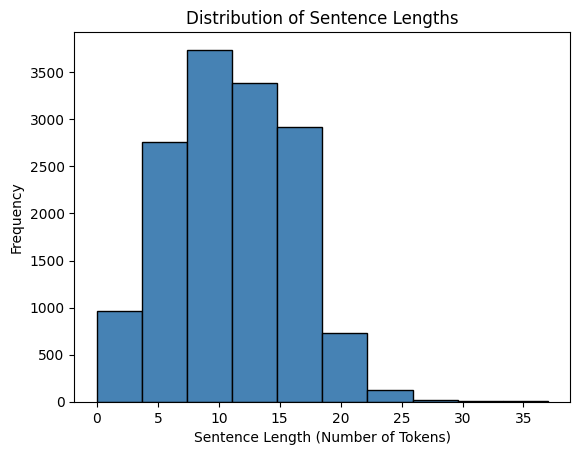

In [7]:
sentence_lengths = []
for token in tokens:
    sentence_lengths.append(len(token))

plt.hist(sentence_lengths, color='steelblue', edgecolor='black')
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length (Number of Tokens)')
plt.ylabel('Frequency')
plt.show()

##### Plot top 10 most frequent words and characters with a bar plot.

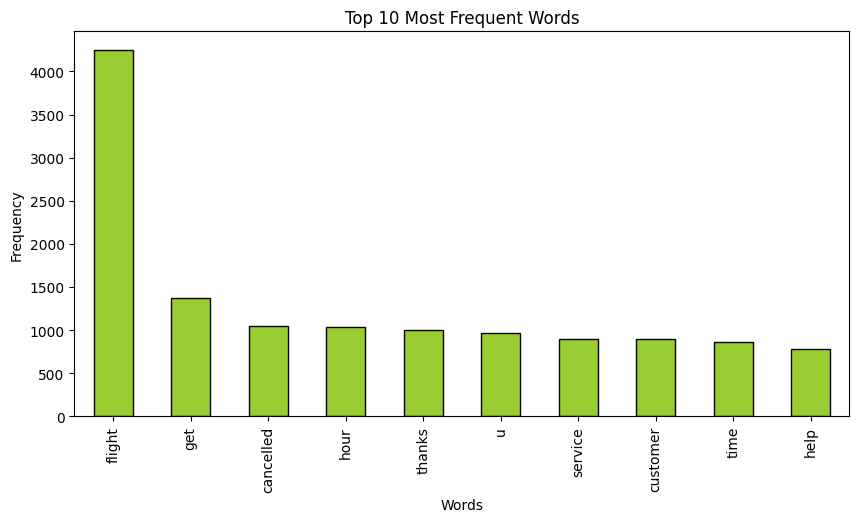

In [8]:
tokenizer = RegexpTokenizer(r'\w+')
word_freq = pd.Series([''.join(tokenizer.tokenize(word)) for words in tokens for word in words if word.isalpha()]).value_counts()
word_freq.head(10).plot(kind='bar', figsize=(10, 5), color='yellowgreen', edgecolor='black')
plt.title("Top 10 Most Frequent Words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

##### Perform advanced EDA by creating word cloud to explore word frequency.

(-0.5, 799.5, 399.5, -0.5)

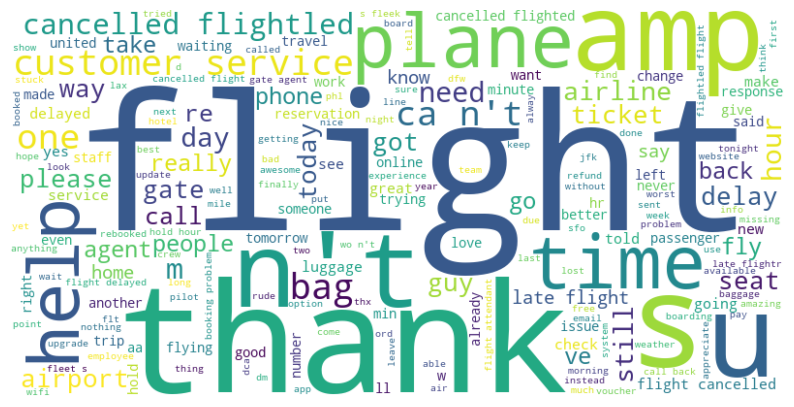

In [9]:
k= (' '.join(tweets_df['text']))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(k)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

##### Create a corpus from the filtered data, select the number of topics and train the LDA model.

In [10]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(tweets_df['text'])
corpus = Sparse2Corpus(X, documents_columns=False)
id2word = {i: word for i, word in enumerate(vectorizer.get_feature_names_out())}
num_topics = 3
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=id2word, passes=10)
for topic in lda_model.print_topics(num_topics=num_topics, num_words=10):
    print(topic)

(0, '0.012*"ticket" + 0.009*"aa" + 0.009*"seat" + 0.009*"airline" + 0.009*"would" + 0.007*"like" + 0.005*"right" + 0.005*"sure" + 0.005*"go" + 0.005*"love"')
(1, '0.089*"flight" + 0.026*"cancelled" + 0.016*"get" + 0.014*"need" + 0.013*"flightled" + 0.011*"plane" + 0.010*"delayed" + 0.010*"tomorrow" + 0.009*"hour" + 0.007*"help"')
(2, '0.019*"service" + 0.018*"customer" + 0.017*"call" + 0.014*"hold" + 0.014*"thanks" + 0.013*"hour" + 0.012*"get" + 0.011*"phone" + 0.011*"help" + 0.010*"time"')


#### 2. Feature Extraction (Vectorization)

##### Encode sentiment labels and set X as texts and numeric labels as y.

In [11]:
label_encoder = LabelEncoder()
tweets_df['label'] = label_encoder.fit_transform(tweets_df['airline_sentiment'])

X = tweets_df['text'].values
y = tweets_df['label'].values

##### Initialize TF-IDF Vectorizer, fit and transform the tweet texts to a dataframe and specify the column names.

In [12]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=100, stop_words="english")
X_tfidf = tfidf_vectorizer.fit_transform(X).toarray()
X_tfidf = np.array(X_tfidf, dtype=np.float32)

##### Using the Word2Vec and FastText model to generate word embeddings and the vectorize function processes each sentence and returns a vector by averaging the word vectors of the words in the sentence.

In [13]:
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [model.wv[word] for word in words if word in model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)
    
sentences = [sentence.split() for sentence in X]
model = Word2Vec(sentences, vector_size=100, window=5, sg=0)
X_word2vec = np.array([vectorize(sentence) for sentence in X])

model = FastText(sentences, vector_size=100, window=5, min_count=1, sg=0, epochs=10)
X_fasttext = np.array([vectorize(sentence) for sentence in X])

#### 3. Build the ANN Classifier

##### Split the data into 80% training and 20% testing

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

##### The following code snippet provided in the course references (Explanation in Kaggle: Deep Tutorial 1 ANN and Classification).

In [15]:
model = Sequential()

# Adding the input layer and specify the input shape here
model.add(Input(shape=(X_tfidf.shape[1],)))

# Adding the first hidden layer
model.add(Dense(units=6, kernel_initializer='uniform', activation='relu'))

# Adding the second hidden layer
model.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN | means applying SGD on the whole ANN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
history = model.fit(X_train, y_train, batch_size = 10, epochs = 100,verbose = 0)

score, acc = model.evaluate(X_train, y_train, batch_size=10)
print('Train score:', score)
print('Train accuracy:', acc)

# Part 3 - Making predictions and evaluating the model
# Predicting the Test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

print('*'*20)
score, acc = model.evaluate(X_test, y_test, batch_size=10)
print('Test score:', score)
print('Test accuracy:', acc)

1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5835 - loss: -15840.8750
Train score: -14772.794921875
Train accuracy: 0.5844433307647705
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
********************
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5757 - loss: -13744.6689 
Test score: -13494.2353515625
Test accuracy: 0.5853825211524963


##### Ιn the above code snippet, improve ANN by adding dropout layer. The fraction of input units is 0.1 and used to reduce overfitting. Adding early stopping monitors validation loss and stops training when once the metric has stopped improving.

In [16]:
model = Sequential()

# Adding the input layer and specify the input shape here
model.add(Input(shape=(X_tfidf.shape[1],)))

# Adding the first hidden layer
model.add(Dense(units=6, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(rate = 0.1))

# Adding the second hidden layer
model.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(rate = 0.1))

# Adding the output layer
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN | means applying SGD on the whole ANN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Stop training - epochs to wait before stop training if there is no further improvement 
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5)

# Fitting the ANN to the Training set
history = model.fit(X_train, y_train, batch_size = 10, epochs = 100, verbose = 0, validation_data=(X_test, y_test), callbacks=[early_stopping])

score, acc = model.evaluate(X_train, y_train, batch_size=10)
print('Train score:', score)
print('Train accuracy:', acc)

# Part 3 - Making predictions and evaluating the model
# Predicting the Test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

print('*'*20)
score, acc = model.evaluate(X_test, y_test, batch_size=10)
print('Test score:', score)
print('Test accuracy:', acc)

1172/1172 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5006 - loss: -104268.3203
Train score: -98148.6640625
Train accuracy: 0.5009391903877258
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
********************
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5025 - loss: -92480.8672  
Test score: -91387.8359375
Test accuracy: 0.5034152865409851


#### 4. Performance Metrics

In [17]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
cm = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.5034
Precision: 0.3769
Recall: 0.4425
F1 Score: 0.3521


#### 5. Visualization

##### Plot the training and validation loss curves to visualize the model's performance during training

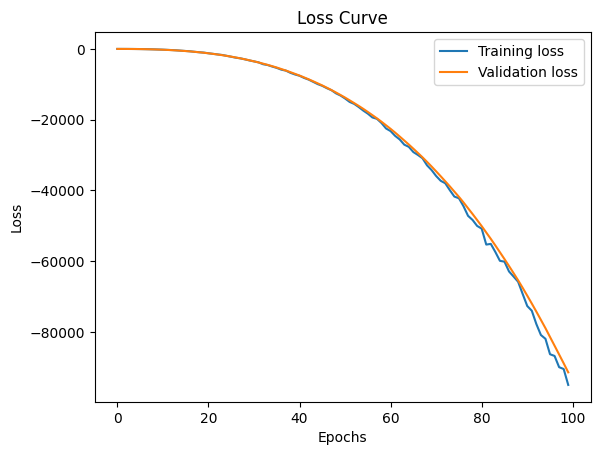

In [18]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

##### Plot the confusion matrix with the help of the seaborn heatmap.

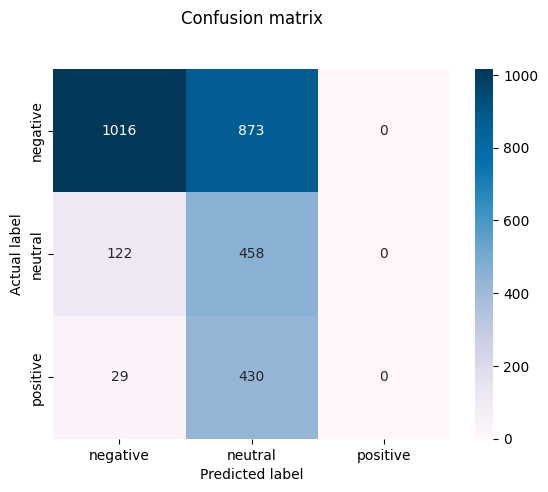

In [19]:
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="PuBu" ,fmt='g', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()